# Afriat

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import tqdm

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import create_random_mask
from tardis._utils.warnings import suppress_stdout
import sklearn
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [4]:
def read_adata():
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    return adata

In [5]:
metrics = []

In [6]:
with suppress_stdout(), warnings.catch_warnings():
    warnings.simplefilter("ignore")
    metric = dict()
    model_name = "afriat_v2_4_1"
    metric["model_name"] = model_name
    metric["model_desc"] = "together"
    adata = read_adata()
    dir_path = os.path.join(
        tardis.config.io_directories["models"],
        model_name
    )
    vae = tardis.MyModel.load(dir_path=dir_path, adata=adata)
    from tardis._disentanglementmanager import DisentanglementManager as DM
    adata.obs["validation"] = "train"
    adata.obs["validation"].iloc[vae.validation_indices] = "validation"

    metric.update({"r2": vae.get_reconstruction_r2_training(top_n=[])})
    metric.update({"mi_zone": vae.get_MI_normalized_training("zone")})
    metric.update({"mi_status_control": vae.get_MI_normalized_training("status_control")})
    metric.update({"mi_time_cat": vae.get_MI_normalized_training("time_cat")})
    metric.update({"knn_zone": vae.get_knn_purity_training("zone")})
    metric.update({"knn_time_cat": vae.get_knn_purity_training("time_cat")})
    metric.update({"knn_status_control": vae.get_knn_purity_training("status_control")})

    data = vae.get_latent_representation()
    factors_indices = sorted([[indice, config.obs_key] for config in DM.configurations.items for indice in config.reserved_latent_indices])
    factors = np.vstack([sklearn.preprocessing.LabelEncoder().fit_transform(
        adata.obs[j].copy().astype(str).values.flatten()
    ) for i, j in factors_indices]).T
    data = data[:, [i for i, j in factors_indices]]
    
    metric.update({"maxmig": {
        "all": np.mean(vae.get_MI_precalculated(data=data, factors=factors, variation="maxMIG", discretization_bins=256)),
        "validation": np.mean(vae.get_MI_precalculated(data=data[vae.validation_indices, :], factors=factors[vae.validation_indices, :], variation="maxMIG", discretization_bins=256)),
        "train": np.mean(vae.get_MI_precalculated(data=data[vae.train_indices, :], factors=factors[vae.train_indices, :], variation="maxMIG", discretization_bins=256))
    }})

    metrics.append(metric)
    del adata, vae, DM, model_name, metric, dir_path, factors_indices, factors, data
    gc.collect()

In [7]:
with suppress_stdout(), warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata = read_adata()
    metric = dict()
    metric["model_name"] = "afriat_v1_1;afriat_v3_1;afriat_v4_1"
    metric["model_desc"] = "status_control;zone;time_cat"
    vaes = dict()
    comparisons_path = os.path.join(
        tardis.config.io_directories["processed"], "figures",
        "maxmig_models.pickle"
    )
    # Load dictionary from a pickle file
    with open(comparisons_path, 'rb') as f:
        metrics.extend(pickle.load(f))
    dir_path = os.path.join(
        tardis.config.io_directories["models"],
        "afriat_v1_1"
    )
    vaes["status_control"] = tardis.MyModel.load(dir_path=dir_path, adata=adata)
    dir_path = os.path.join(
        tardis.config.io_directories["models"],
        "afriat_v3_1"
    )
    vaes["zone"] = tardis.MyModel.load(dir_path=dir_path, adata=adata)
    dir_path = os.path.join(
        tardis.config.io_directories["models"],
        "afriat_v4_1"
    )
    vaes["time_cat"] = tardis.MyModel.load(dir_path=dir_path, adata=adata)

    for k in vaes:
        adata.obs[f"validation_{k}"] = "train"
        adata.obs[f"validation_{k}"].iloc[vaes[k].validation_indices] = "validation"

    factors_indices = sorted([[k, i] for k in vaes for i in range(8)])
    datas = {j: vaes[j].get_latent_representation() for j in vaes}
    factors_indices_obs = sorted({i for i, j in factors_indices})

    factors = np.vstack([sklearn.preprocessing.LabelEncoder().fit_transform(
        adata.obs[j].copy().astype(str).values.flatten()
    ) for j, i in factors_indices]).T
    data = np.hstack([datas[d][:, range(8)] for d in factors_indices_obs])
    vae = vaes["zone"]
    metric.update({"maxmig": {
        "all": np.mean(vae.get_MI_precalculated(data=data, factors=factors, variation="maxMIG", discretization_bins=256)),
        "validation_zone": np.mean(vae.get_MI_precalculated(data=data[vaes["zone"].validation_indices, :], factors=factors[vaes["zone"].validation_indices, :], variation="maxMIG", discretization_bins=256)),
        "train_zone": np.mean(vae.get_MI_precalculated(data=data[vaes["zone"].train_indices, :], factors=factors[vaes["zone"].train_indices, :], variation="maxMIG", discretization_bins=256)),
        "validation_status_control": np.mean(vae.get_MI_precalculated(data=data[vaes["status_control"].validation_indices, :], factors=factors[vaes["status_control"].validation_indices, :], variation="maxMIG", discretization_bins=256)),
        "train_status_control": np.mean(vae.get_MI_precalculated(data=data[vaes["status_control"].train_indices, :], factors=factors[vaes["status_control"].train_indices, :], variation="maxMIG", discretization_bins=256)),
        "validation_time_cat": np.mean(vae.get_MI_precalculated(data=data[vaes["time_cat"].validation_indices, :], factors=factors[vaes["time_cat"].validation_indices, :], variation="maxMIG", discretization_bins=256)),
        "train_time_cat": np.mean(vae.get_MI_precalculated(data=data[vaes["time_cat"].train_indices, :], factors=factors[vaes["time_cat"].train_indices, :], variation="maxMIG", discretization_bins=256)),
    }})
    metrics.append(metric)
    del dir_path, adata, vae, vaes, datas, factors_indices, factors_indices_obs, factors, data, metric
    gc.collect()

In [8]:
with suppress_stdout(), warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for model_name, model_desc in [["afriat_v1_1", "status_control"], ["afriat_v3_1", "zone"], ["afriat_v4_1", "time_cat"]]:
        adata = read_adata()
        metric = dict()
        metric["model_name"] = model_name
        metric["model_desc"] = model_desc
    
        dir_path = os.path.join(
            tardis.config.io_directories["models"],
            model_name
        )
        vae = tardis.MyModel.load(dir_path=dir_path, adata=adata)

        from tardis._disentanglementmanager import DisentanglementManager as DM
        adata.obs["validation"] = "train"
        adata.obs["validation"].iloc[vae.validation_indices] = "validation"
    
        metric.update({"r2": vae.get_reconstruction_r2_training(top_n=[])})
        metric.update({f"mi_{model_desc}": vae.get_MI_normalized_training(model_desc)})
        metric.update({f"knn_{model_desc}": vae.get_knn_purity_training(model_desc)})
        
        metrics.append(metric)
        del adata, vae, DM, model_name, model_desc, metric, dir_path
        gc.collect()

# tidy-up

In [9]:
metrics

[{'model_name': 'afriat_v2_4_1',
  'model_desc': 'together',
  'r2': {('validation', 'total'): 0.9992649753751152,
   ('train', 'total'): 0.9995150008672429},
  'mi_zone': {('validation', 'reserved'): 0.9984358727426297,
   ('validation', 'unreserved'): 0.10115815244537676,
   ('train', 'reserved'): 0.998713989002184,
   ('train', 'unreserved'): 0.05535010583741584},
  'mi_status_control': {('validation', 'reserved'): 0.9917252897308235,
   ('validation', 'unreserved'): 0.20399119080955294,
   ('train', 'reserved'): 0.9928320402813209,
   ('train', 'unreserved'): 0.14720750037775082},
  'mi_time_cat': {('validation', 'reserved'): 0.9692151235353923,
   ('validation', 'unreserved'): 0.18063049596730268,
   ('train', 'reserved'): 0.9677143943771795,
   ('train', 'unreserved'): 0.09944159508860503},
  'knn_zone': {('validation', 'reserved'): 1.0,
   ('validation', 'unreserved'): 0.584681952683234,
   ('train', 'reserved'): 1.0,
   ('train', 'unreserved'): 0.5804389831709783},
  'knn_time_

In [10]:
_general_comparison = [{k: v for k, v in i.items() if k in ["model_name", "model_desc", "maxmig"]} for i in metrics if "maxmig" in i]
rows = []
for item in _general_comparison:
    for key, value in item['maxmig'].items():
        rows.append({
            # 'model_name': item['model_name'],
            'Model': item['model_desc'],
            'Split': key,
            'maxMIG': value
        })
df = pd.DataFrame(rows).copy()

rename_dict_model_name = {
    "together": r"Tardis $_{\mathrm{Multiple}}$", 
    "cpa": "CPA",
    "ffvae": "FFVAE",
    "biolord": "Biolord",
    "btcvae": r"$\beta$-TCVAE",
    "status_control;zone;time_cat": r"Tardis $_{\mathrm{Single}}$",
}

rename_set = {
    "validation_zone": "Validation", 
    "train_zone": "Train",
    "validation_status_control": "Validation",
    "train_status_control": "Train",
    "validation_time_cat": "Validation",
    "train_time_cat": "Train",
    "validation": "Validation",
    "train": "Train",
    "all": "Validation",
}

df["Model"].replace(to_replace=rename_dict_model_name, inplace=True)
df["Split"].replace(to_replace=rename_set, inplace=True)
df = df[df["Split"] == "Validation"]

In [11]:
tardis.config.io_directories

{'processed': '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed',
 'temp': '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/_temporary',
 'figures': '/home/icb/kemal.inecik/work/codes/tardis/training/server/figures',
 'models': '/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models'}

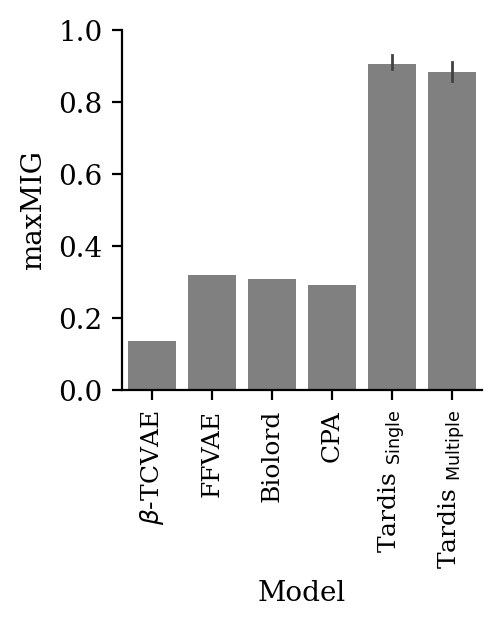

In [12]:
figsize = (3, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)

sns.barplot(df, x="Model",  y="maxMIG", 
            order=[r"$\beta$-TCVAE", "FFVAE", "Biolord", "CPA", r"Tardis $_{\mathrm{Single}}$", r"Tardis $_{\mathrm{Multiple}}$"],
            color='gray',
            err_kws={'linewidth': 1},
)
plt.ylim(0, 1)
sns.despine()

plt.xticks(fontsize=9, rotation=90)  # Correct way to set fontsize
plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", "fig2_model_comparison.pdf"), format="pdf")

In [13]:
_general_comparison = [{k: v for k, v in i.items() if any([k.startswith(mm) for mm in ["model_name", "model_desc", "knn_", "mi_"]])} for i in metrics]
_general_comparison = [i for i in _general_comparison if len(i)>2]

rows = []
# Loop over each model in the data
for model in _general_comparison:
    model_name = model['model_name']
    model_desc = model['model_desc']
    
    # Loop over each key in the model dictionary that represents a different metric
    for metric, values in model.items():
        if metric not in ['model_name', 'model_desc']:  # Skip non-metric keys
            # Loop over each key in the metric dictionary
            for (split_type, reservation_type), value in values.items():
                # Create a dictionary for each row
                if metric.startswith("mi_"):
                    m1, m2 = metric.split("mi_")
                    m1 = "Mutual Information"
                else:
                    m1, m2 = metric.split("knn_")
                    m1 = "KNN Purity"
                
                row = {
                    # 'Model Name': model_name,
                    'Model': model_desc,
                    'Metric': m1,
                    'Covariate': m2,
                    'Split': split_type,
                    'Latent Subset': reservation_type,
                    'Value': value
                }
                rows.append(row)

df = pd.DataFrame(rows)

rename_dict_model_name = {
    "together": r"Tardis $_{\mathrm{Multiple}}$", 
    "status_control": r"Tardis $_{\mathrm{Status}}$", 
    "zone": r"Tardis $_{\mathrm{Zone}}$", 
    "time_cat": r"Tardis $_{\mathrm{Time}}$", 
}

rename_set = {
    "validation_zone": "Validation", 
    "train_zone": "Train",
    "validation_status_control": "Validation",
    "train_status_control": "Train",
    "validation_time_cat": "Validation",
    "train_time_cat": "Train",
    "validation": "Validation",
    "train": "Train",
    "all": "Validation",
}

rename_covar = {
    "zone": "Zone", 
    "time_cat": "Time",
    "status_control": "Status"
}

rename_latent = {
    "unreserved": "Unreserved", 
    "reserved": "Reserved"
}

df["Model"].replace(to_replace=rename_dict_model_name, inplace=True)
df["Split"].replace(to_replace=rename_set, inplace=True)
df["Covariate"].replace(to_replace=rename_covar, inplace=True)
df["Latent Subset"].replace(to_replace=rename_latent, inplace=True)
df["Training"] = "Single"
df["Training"][df["Model"] == r"Tardis $_{\mathrm{Multiple}}$"] = "Multiple"
df

/tmp/ipykernel_517425/730922887.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Training"][df["Model"] == r"Tardis $_{\mathrm{Multiple}}$"] = "Multiple"


,Model,Metric,Covariate,Split,Latent Subset,Value,Training
0,Tardis $_{\mathrm{Multiple}}$,Mutual Information,Zone,Validation,Reserved,0.998436,Multiple
1,Tardis $_{\mathrm{Multiple}}$,Mutual Information,Zone,Validation,Unreserved,0.101158,Multiple
2,Tardis $_{\mathrm{Multiple}}$,Mutual Information,Zone,Train,Reserved,0.998714,Multiple
3,Tardis $_{\mathrm{Multiple}}$,Mutual Information,Zone,Train,Unreserved,0.055350,Multiple
4,Tardis $_{\mathrm{Multiple}}$,Mutual Information,Status,Validation,Reserved,0.991725,Multiple
5,Tardis $_{\mathrm{Multiple}}$,Mutual Information,Status,Validation,Unreserved,0.203991,Multiple
6,Tardis $_{\mathrm{Multiple}}$,Mutual Information,Status,Train,Reserved,0.992832,Multiple
7,Tardis $_{\mathrm{Multiple}}$,Mutual Information,Status,Train,Unreserved,0.147208,Multiple
8,Tardis $_{\mathrm{Multiple}}$,Mutual Information,Time,Validation,Reserved,0.969215,Multiple
9,Tardis $_{\mathrm{Multiple}}$,Mutual Information,Time,Validation,Unreserved,0.180630,Multiple


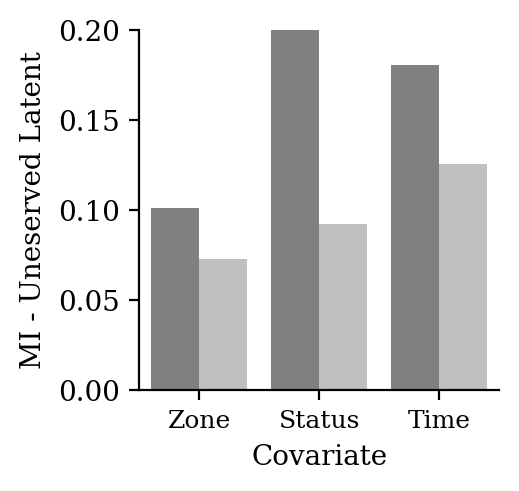

In [14]:
df_mi = df[(df["Metric"] == "Mutual Information") & (df["Latent Subset"] == "Unreserved") & (df["Split"] == "Validation")]

figsize = (3, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)
sns.barplot(df_mi, x="Covariate", y="Value", hue="Training", palette=["gray", "silver"])

plt.ylim(0, 0.2)
sns.despine()
plt.ylabel("MI - Uneserved Latent")

plt.legend().set_visible(False)
plt.xticks(fontsize=9)  # Correct way to set fontsize
plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", "fig2_unreserved_mi.pdf"), format="pdf")

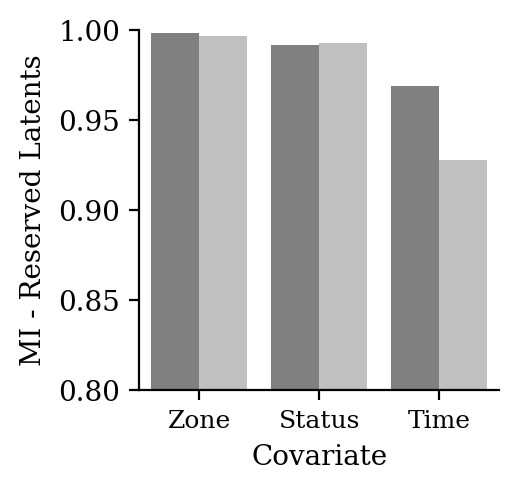

In [15]:
df_mi = df[(df["Metric"] == "Mutual Information") & (df["Latent Subset"] == "Reserved") & (df["Split"] == "Validation")]

figsize = (3, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)
sns.barplot(df_mi, x="Covariate", y="Value", hue="Training", palette=["gray", "silver"])

plt.ylim(0.8, 1)
sns.despine()
plt.ylabel("MI - Reserved Latents")

plt.legend().set_visible(False)
plt.xticks(fontsize=9)  # Correct way to set fontsize
plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", "fig2_reserved_mi.pdf"), format="pdf")

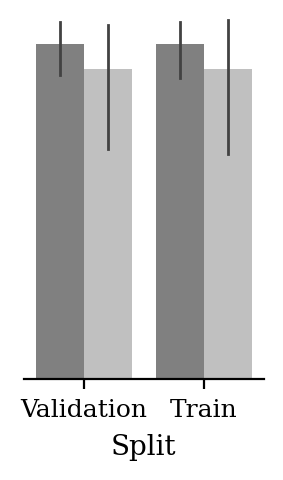

In [16]:
df_mi = df[(df["Metric"] == "Mutual Information") & (df["Latent Subset"] == "Reserved")]

figsize = (2, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)
sns.barplot(df_mi, x="Split", y="Value", hue="Training", palette=["gray", "silver"], err_kws={'linewidth': 1})

plt.ylim(0.8, 1)
sns.despine(left=True)
plt.ylabel("")
plt.gca().set_yticks([])

plt.legend().set_visible(False)
plt.xticks(fontsize=9)  # Correct way to set fontsize

plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", "fig2_reserved_mi_split.pdf"), format="pdf")

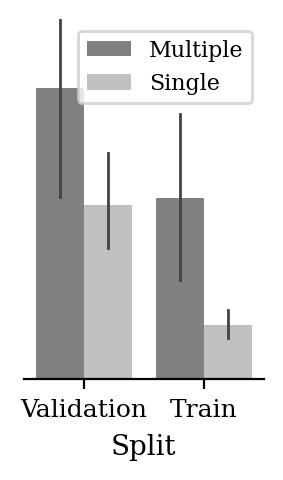

In [17]:
df_mi = df[(df["Metric"] == "Mutual Information") & (df["Latent Subset"] == "Unreserved")]

figsize = (2, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)
sns.barplot(df_mi, x="Split", y="Value", hue="Training", palette=["gray", "silver"], err_kws={'linewidth': 1})

plt.ylim(0, 0.2)
sns.despine(left=True)
plt.ylabel("")
plt.gca().set_yticks([])

plt.legend(loc='upper right', prop={'size': 8})  # Place legend outside
plt.xticks(fontsize=9)  # Correct way to set fontsize
plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", "fig2_unreserved_mi_split.pdf"), format="pdf")

# UMAP

In [18]:
model_name = "afriat_v2_4_1"
adata = read_adata()
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    model_name
)
vae = tardis.MyModel.load(dir_path=dir_path, adata=adata)

INFO     File /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v2_4_1/model.pt already         
         downloaded                                                                                                


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [19]:
_data = vae.get_latent_representation()
result = {
    "all": ad.AnnData(X=_data.copy(), obs=adata.obs.copy()),
    "train": ad.AnnData(X=_data[vae.train_indices].copy(), obs=adata.obs.iloc[vae.train_indices].copy()),
    "validation": ad.AnnData(X=_data[vae.validation_indices].copy(), obs=adata.obs.iloc[vae.validation_indices].copy()),
}

In [20]:
from tardis._disentanglementmanager import DisentanglementManager as DM
factors_indices = sorted([[indice, config.obs_key] for config in DM.configurations.items for indice in config.reserved_latent_indices])
def get_factors_indices(key):
    return sorted([i for i, j in factors_indices if j == key])

In [ ]:
figsize = (2, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)
sns.barplot(df_mi, x="Split", y="Value", hue="Training", palette=["gray", "silver"], err_kws={'linewidth': 1})


In [21]:
adata.obs

,mouse,experiment,time_int,time_cat,zone,status_control,_scvi_batch,_scvi_labels
AACCTTG_IMM-feb20_M10_P29_24hpi,M10,IMM-feb20,24.0,24.0,Pericentral,Infected,0,0
AAGACTC_IMM-feb20_M10_P29_24hpi,M10,IMM-feb20,24.0,24.0,Periportal,Infected,0,0
AAGGCTA_IMM-feb20_M10_P29_24hpi,M10,IMM-feb20,24.0,24.0,Periportal,Infected,0,0
AATGCCG_IMM-feb20_M10_P29_24hpi,M10,IMM-feb20,24.0,24.0,Pericentral,Infected,0,0
ACAATCG_IMM-feb20_M10_P29_24hpi,M10,IMM-feb20,24.0,24.0,Periportal,Infected,0,0
...,...,...,...,...,...,...,...,...
TTCCTGA_IMM-Jan22_M24_P24_NI,M24,IMM-Jan22,0.0,0.0,Periportal,Control,0,0
TTGCACC_IMM-Jan22_M24_P24_NI,M24,IMM-Jan22,0.0,0.0,Periportal,Control,0,0
TTGCAGA_IMM-Jan22_M24_P24_NI,M24,IMM-Jan22,0.0,0.0,Periportal,Control,0,0
TTGCCTA_IMM-Jan22_M24_P24_NI,M24,IMM-Jan22,0.0,0.0,Periportal,Control,0,0


In [29]:
import random
my_list = list(range(len(adata)))

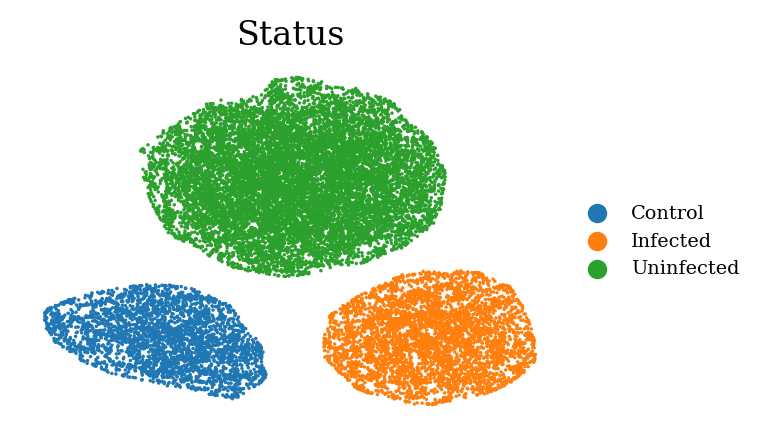

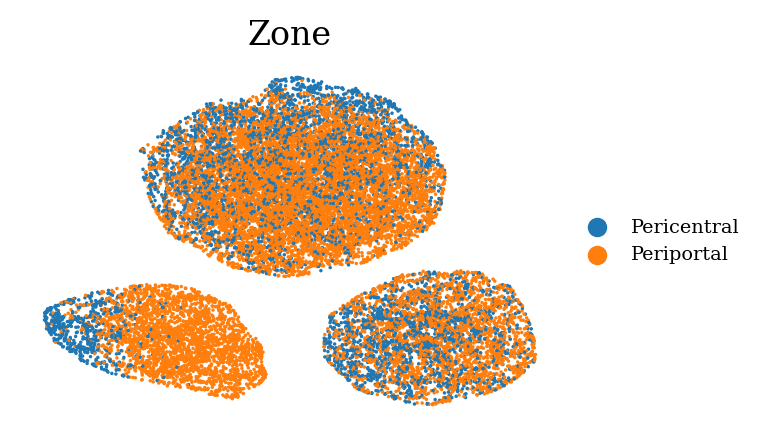

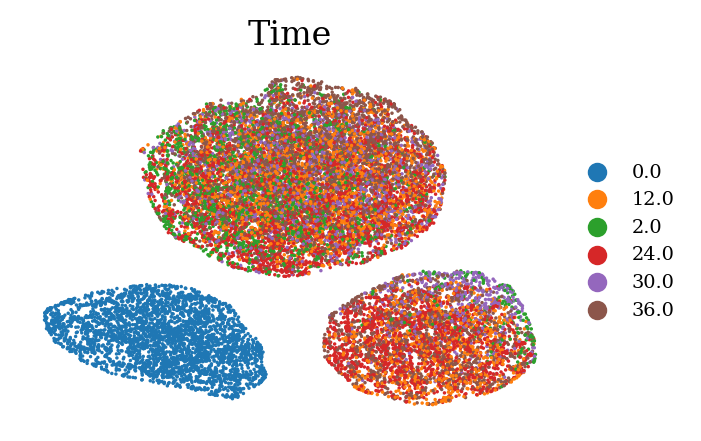

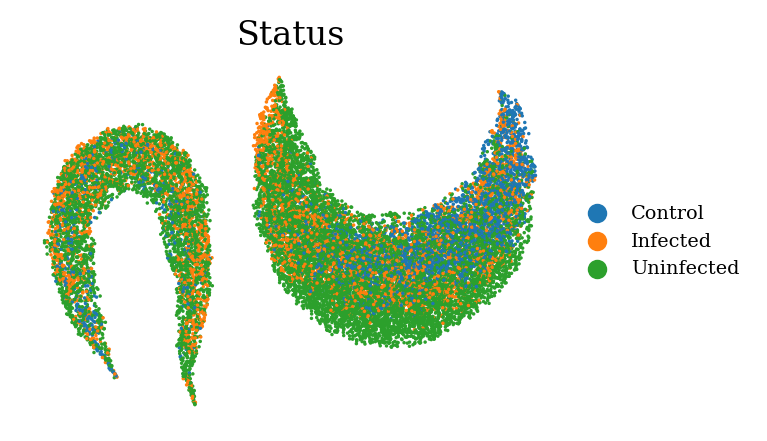

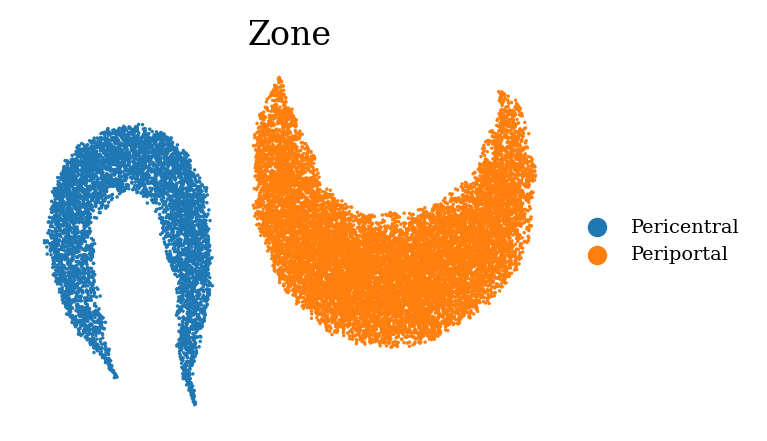

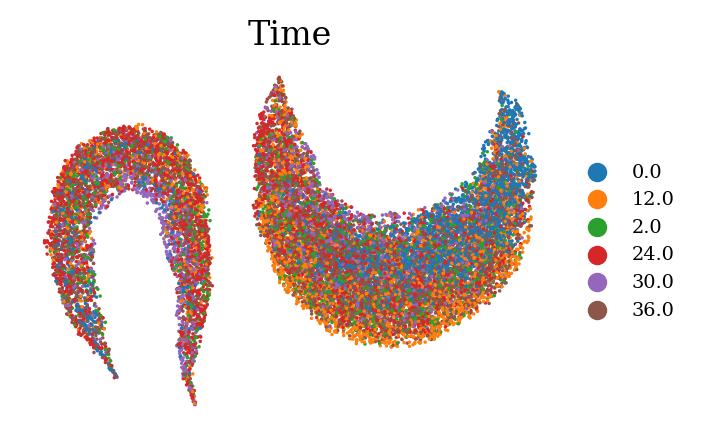

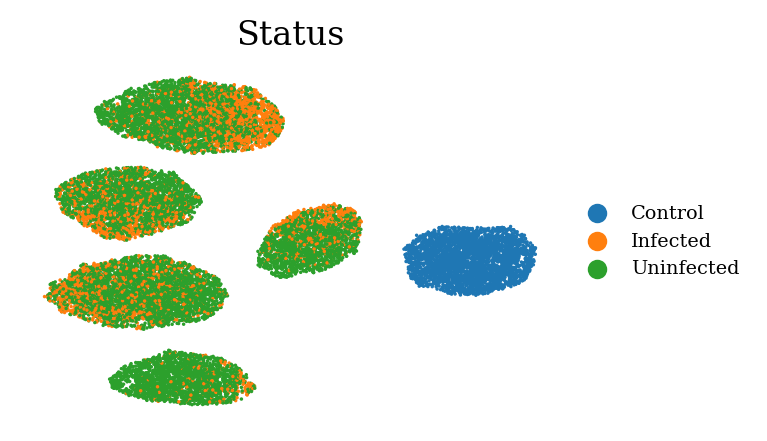

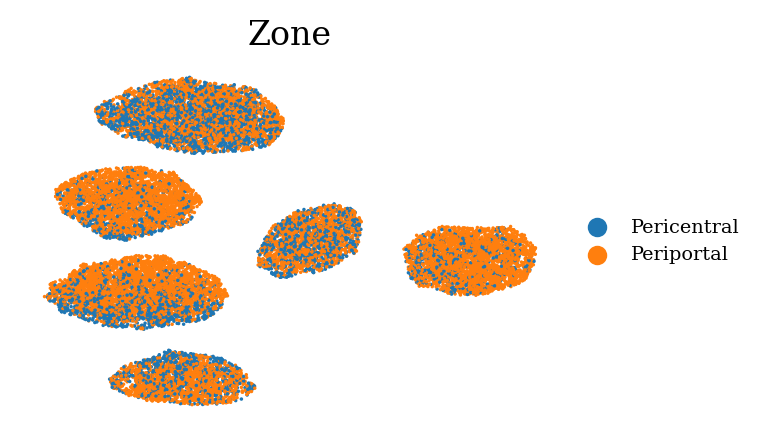

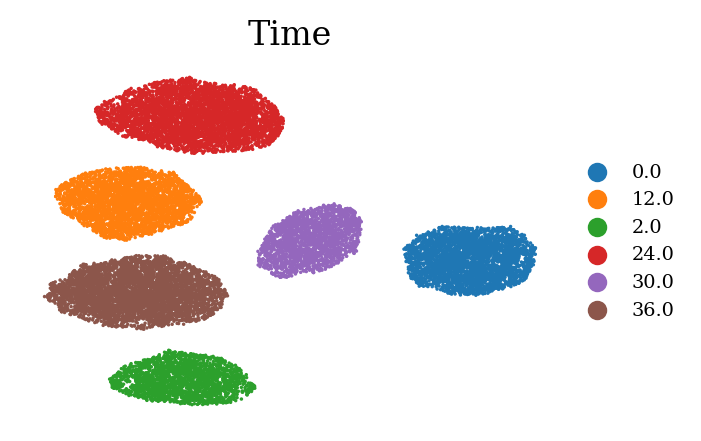

In [37]:
training_set = "all"

with suppress_stdout(), warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for obs_key in ["status_control", "zone", "time_cat"]:
        latent_subset = result[training_set][:, get_factors_indices(obs_key)].copy()
        random.shuffle(my_list)
        latent_subset = latent_subset[my_list].copy()
        
        sc.pp.neighbors(latent_subset)
        sc.tl.umap(latent_subset)
        
        for ccc, ccc1 in zip(["status_control", "zone", "time_cat"], ["Status", "Zone", "Time"]):
            figsize = (4.5, 3)
            fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
            fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)
            
            sc.pl.umap(
                latent_subset,
                color=ccc,
                # s=8,
                ncols=1,
                frameon=False,
                legend_fontsize="x-small",
                show=False,
                # alpha=0.5,
                title=ccc1,
                ax=plt.gca(),
                # add_outline=True,
                # outline_width = (0.2, 0.1)
            )
        
            plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", f"fig2_afriat_umap_{obs_key}_{ccc1}.pdf"), format="pdf")

In [ ]:


with suppress_stdout(), warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for ccc, ccc1 in zip(["status_control", "zone", "time_cat"], ["Status", "Zone", "Time"]):
        figsize = (4.5, 3)
        fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
        fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)
        
        sc.pl.umap(
            latent_subset,
            color=ccc,
            # s=8,
            ncols=1,
            frameon=False,
            legend_fontsize="x-small",
            show=False,
            # alpha=0.5,
            title=ccc1,
            ax=plt.gca(),
            # add_outline=True,
            # outline_width = (0.2, 0.1)
        )
    
        plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", f"fig2_afriat_umap_{obs_key}_{ccc1}.pdf"), format="pdf")